# Trader Performance vs Market Sentiment


This notebook covers:
- **Part A**: Data preparation & key metrics
- **Part B**: Analysis — PnL, behavior, trader segments, insights
- **Part C**: Actionable strategy recommendations
- **Bonus**: Predictive model + trader clustering

In [131]:
# Install if needed
# pip install pandas numpy matplotlib seaborn scikit-learn xgboost plotly

import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import matplotlib.ticker as mticker
import seaborn as sns
import warnings
warnings.filterwarnings('ignore')

from sklearn.preprocessing import LabelEncoder
from sklearn.ensemble import RandomForestClassifier, GradientBoostingClassifier
from sklearn.model_selection import train_test_split
from sklearn.metrics import classification_report, confusion_matrix, ConfusionMatrixDisplay
from sklearn.cluster import KMeans
from sklearn.preprocessing import StandardScaler
from sklearn.decomposition import PCA

sns.set_theme(style='whitegrid', palette='muted')
plt.rcParams['figure.dpi'] = 120
plt.rcParams['figure.figsize'] = (12, 5)

print('All libraries loaded successfully ')

All libraries loaded successfully 


---
## Part A — Data Preparation

### A1. Load Datasets

In [132]:
# ── UPDATE THESE PATHS TO MATCH YOUR LOCAL FILES ──
TRADER_PATH     = 'historical_data.csv'
SENTIMENT_PATH  = 'fear_greed_index.csv'

trader_raw   = pd.read_csv(TRADER_PATH)
sentiment_raw = pd.read_csv(SENTIMENT_PATH)

print('=== Trader Data ===')
print(f'Rows: {trader_raw.shape[0]:,}  |  Columns: {trader_raw.shape[1]}')
print(trader_raw.dtypes)
print('\n=== Sentiment Data ===')
print(f'Rows: {sentiment_raw.shape[0]:,}  |  Columns: {sentiment_raw.shape[1]}')
print(sentiment_raw.dtypes)

=== Trader Data ===
Rows: 211,224  |  Columns: 16
Account              object
Coin                 object
Execution Price     float64
Size Tokens         float64
Size USD            float64
Side                 object
Timestamp IST        object
Start Position      float64
Direction            object
Closed PnL          float64
Transaction Hash     object
Order ID              int64
Crossed                bool
Fee                 float64
Trade ID            float64
Timestamp           float64
dtype: object

=== Sentiment Data ===
Rows: 2,644  |  Columns: 4
timestamp          int64
value              int64
classification    object
date              object
dtype: object


In [133]:
print('=== Trader Data — First 5 rows ===')
display(trader_raw.head())
print('\n=== Sentiment Data — First 5 rows ===')
display(sentiment_raw.head())

=== Trader Data — First 5 rows ===


,Account,Coin,Execution Price,Size Tokens,Size USD,Side,Timestamp IST,Start Position,Direction,Closed PnL,Transaction Hash,Order ID,Crossed,Fee,Trade ID,Timestamp
0,0xae5eacaf9c6b9111fd53034a602c192a04e082ed,@107,7.9769,986.87,7872.16,BUY,02-12-2024 22:50,0.000000,Buy,0.0,0xec09451986a1874e3a980418412fcd0201f500c95bac...,52017706630,True,0.345404,8.950000e+14,1.730000e+12
1,0xae5eacaf9c6b9111fd53034a602c192a04e082ed,@107,7.9800,16.00,127.68,BUY,02-12-2024 22:50,986.524596,Buy,0.0,0xec09451986a1874e3a980418412fcd0201f500c95bac...,52017706630,True,0.005600,4.430000e+14,1.730000e+12
2,0xae5eacaf9c6b9111fd53034a602c192a04e082ed,@107,7.9855,144.09,1150.63,BUY,02-12-2024 22:50,1002.518996,Buy,0.0,0xec09451986a1874e3a980418412fcd0201f500c95bac...,52017706630,True,0.050431,6.600000e+14,1.730000e+12
3,0xae5eacaf9c6b9111fd53034a602c192a04e082ed,@107,7.9874,142.98,1142.04,BUY,02-12-2024 22:50,1146.558564,Buy,0.0,0xec09451986a1874e3a980418412fcd0201f500c95bac...,52017706630,True,0.050043,1.080000e+15,1.730000e+12
4,0xae5eacaf9c6b9111fd53034a602c192a04e082ed,@107,7.9894,8.73,69.75,BUY,02-12-2024 22:50,1289.488521,Buy,0.0,0xec09451986a1874e3a980418412fcd0201f500c95bac...,52017706630,True,0.003055,1.050000e+15,1.730000e+12



=== Sentiment Data — First 5 rows ===


,timestamp,value,classification,date
0,1517463000,30,Fear,2018-02-01
1,1517549400,15,Extreme Fear,2018-02-02
2,1517635800,40,Fear,2018-02-03
3,1517722200,24,Extreme Fear,2018-02-04
4,1517808600,11,Extreme Fear,2018-02-05


### A2. Missing Values & Duplicates

In [134]:
def audit(df, name):
    print(f'\n──── {name} ────')
    miss = df.isnull().sum()
    miss_pct = (miss / len(df) * 100).round(2)
    summary = pd.DataFrame({'missing': miss, 'missing_%': miss_pct})
    print(summary[summary['missing'] > 0].to_string() or 'No missing values')
    dups = df.duplicated().sum()
    print(f'Duplicate rows: {dups}')

audit(trader_raw,    'Trader Data')
audit(sentiment_raw, 'Sentiment Data')


──── Trader Data ────
Empty DataFrame
Columns: [missing, missing_%]
Index: []
Duplicate rows: 0

──── Sentiment Data ────
Empty DataFrame
Columns: [missing, missing_%]
Index: []
Duplicate rows: 0


### A3. Timestamp Conversion & Date Alignment

In [135]:
# ── Sentiment timestamps ──
# Reload fresh data
sentiment = pd.read_csv(SENTIMENT_PATH)
# Convert date column based on its type
if sentiment['date'].dtype == 'int64':
    sentiment['date'] = pd.to_datetime(sentiment['date'], unit='s', utc=True).dt.date
elif sentiment['date'].dtype == 'float64':
    sentiment['date'] = pd.to_datetime(sentiment['date'] * 1e9, unit='s', utc=True).dt.date
elif sentiment['date'].dtype == 'object':
    sentiment['date'] = pd.to_datetime(sentiment['date'], infer_datetime_format=True).dt.date
else:
    sentiment['date'] = sentiment['date'].dt.date
sentiment['date'] = pd.to_datetime(sentiment['date'])

# Standardise classification column name
cls_col = [c for c in sentiment.columns if 'class' in c.lower() or 'sentiment' in c.lower() or 'label' in c.lower()]
print('Sentiment classification column:', cls_col)
sentiment.rename(columns={cls_col[0]: 'sentiment'}, inplace=True)

# Normalise labels
sentiment['sentiment'] = sentiment['sentiment'].str.strip().str.title()
# Collapse Extreme Fear/Greed into Fear/Greed for binary analysis
sentiment['sentiment_binary'] = sentiment['sentiment'].replace(
    {'Extreme Fear': 'Fear', 'Extreme Greed': 'Greed', 'Neutral': 'Neutral'}
)

print('\nSentiment distribution:')
print(sentiment['sentiment'].value_counts())
print('\nSentiment date range:', sentiment['date'].min(), '→', sentiment['date'].max())

Sentiment classification column: ['classification']

Sentiment distribution:
sentiment
Fear             781
Greed            633
Extreme Fear     508
Neutral          396
Extreme Greed    326
Name: count, dtype: int64

Sentiment date range: 2018-02-01 00:00:00 → 2025-05-02 00:00:00


### A4. Standardise Column Names & Clean Trader Data

In [136]:
# Lower-case all column names for consistency
trader.columns = [c.strip().lower().replace(' ', '_') for c in trader.columns]
print('Trader columns:', trader.columns.tolist())

# Map common Hyperliquid column variants
rename_map = {}
for c in trader.columns:
    if 'pnl' in c and 'closed' in c:   rename_map[c] = 'closed_pnl'
    if c in ('px', 'price', 'exec'):    rename_map[c] = 'exec_price'
    if c in ('sz', 'amount'):           rename_map[c] = 'size'
    if c in ('dir', 'direction'):       rename_map[c] = 'side'
    if c in ('user', 'trader'):         rename_map[c] = 'account'
    if 'lev' in c and 'leverage' not in rename_map.values(): rename_map[c] = 'leverage'

trader.rename(columns=rename_map, inplace=True)
print('After rename:', trader.columns.tolist())

# Ensure numeric types
for col in ['closed_pnl', 'size', 'leverage']:
    if col in trader.columns:
        trader[col] = pd.to_numeric(trader[col], errors='coerce')

# Drop exact duplicates
before = len(trader)
trader.drop_duplicates(inplace=True)
print(f'Dropped {before - len(trader)} duplicate rows')

print(f'\nClean trader dataset: {trader.shape}')

Trader columns: ['account', 'coin', 'execution_price', 'size_tokens', 'size', 'side', 'timestamp_ist', 'start_position', 'closed_pnl', 'transaction_hash', 'order_id', 'crossed', 'fee', 'trade_id', 'timestamp', 'datetime', 'date', 'is_long', 'is_win']
After rename: ['account', 'coin', 'execution_price', 'size_tokens', 'size', 'side', 'timestamp_ist', 'start_position', 'closed_pnl', 'transaction_hash', 'order_id', 'crossed', 'fee', 'trade_id', 'timestamp', 'datetime', 'date', 'is_long', 'is_win']
Dropped 0 duplicate rows

Clean trader dataset: (211224, 19)


### A5. Key Metrics per Day per Trader

In [137]:
# Remove duplicate columns if any
trader = trader.loc[:, ~trader.columns.duplicated()]

# Rename columns to match expected names (after lowercasing in previous cell)
rename_map = {
    'side': 'side',
    'closed_pnl': 'closed_pnl',
    'size_usd': 'size',
    # 'leverage' not present in data
}
trader.rename(columns=rename_map, inplace=True)

# ── Determine side values present ──
if 'side' in trader.columns:
    print('Side values:', trader['side'].unique())

def is_long(s):
    if isinstance(s, str):
        return s.strip().upper() in ('B', 'BUY', 'LONG', 'A')
    return False

trader['is_long'] = trader['side'].apply(is_long).astype(int) if 'side' in trader.columns else np.nan
trader['is_win']  = (trader['closed_pnl'] > 0).astype(int) if 'closed_pnl' in trader.columns else np.nan

# Daily per-trader metrics
grp = trader.groupby(['account', 'date'])

daily_trader = grp.agg(
    daily_pnl      = ('closed_pnl', 'sum'),
    n_trades       = ('closed_pnl', 'count'),
    win_rate       = ('is_win',     'mean'),
    avg_size       = ('size',       'mean'),
    long_ratio     = ('is_long',    'mean'),
).reset_index()

print('Daily trader metrics shape:', daily_trader.shape)
display(daily_trader.head())

Side values: ['BUY' 'SELL']
Daily trader metrics shape: (102, 7)


,account,date,daily_pnl,n_trades,win_rate,avg_size,long_ratio
0,0x083384f897ee0f19899168e3b1bec365f52a9012,2024-10-27,-3.275059e+05,462,0.025974,14810.891818,0.300866
1,0x083384f897ee0f19899168e3b1bec365f52a9012,2025-02-19,1.927736e+06,3356,0.405542,16345.241940,0.468415
2,0x23e7a7f8d14b550961925fbfdaa92f5d195ba5bd,2024-10-27,2.060745e+04,320,0.531250,2492.749906,0.453125
3,0x23e7a7f8d14b550961925fbfdaa92f5d195ba5bd,2025-02-19,1.709873e+04,3533,0.435041,1693.351684,0.432494
4,0x23e7a7f8d14b550961925fbfdaa92f5d195ba5bd,2025-06-15,1.017915e+04,3427,0.442369,1533.468395,0.403268


### A6. Merge with Sentiment

In [138]:
merged = daily_trader.merge(sentiment[['date', 'sentiment', 'sentiment_binary']], on='date', how='inner')

print(f'Merged rows: {len(merged):,}')
print(f'Date range : {merged["date"].min()} → {merged["date"].max()}')
print(f'Unique accounts: {merged["account"].nunique():,}')
print('\nSentiment distribution in merged data:')
print(merged['sentiment'].value_counts())

Merged rows: 77
Date range : 2023-03-28 00:00:00 → 2025-02-19 00:00:00
Unique accounts: 32

Sentiment distribution in merged data:
sentiment
Greed            32
Fear             32
Neutral           8
Extreme Greed     5
Name: count, dtype: int64


---
## Part B — Analysis

### B1. PnL & Win Rate — Fear vs Greed Days

In [139]:
# Aggregate to daily market level
daily_market = merged.groupby(['date', 'sentiment_binary']).agg(
    total_pnl   = ('daily_pnl',    'sum'),
    avg_pnl     = ('daily_pnl',    'mean'),
    median_pnl  = ('daily_pnl',    'median'),
    avg_win_rate= ('win_rate',     'mean'),
    n_traders   = ('account',      'nunique'),
    n_trades    = ('n_trades',     'sum'),
).reset_index()

# Summary stats by sentiment
summary_sentiment = merged.groupby('sentiment_binary').agg(
    avg_daily_pnl      = ('daily_pnl',  'mean'),
    median_daily_pnl   = ('daily_pnl',  'median'),
    avg_win_rate       = ('win_rate',   'mean'),
    avg_n_trades       = ('n_trades',   'mean'),
    avg_long_ratio     = ('long_ratio', 'mean'),
    n_obs              = ('account',    'count'),
).round(4)

print('=== Summary by Sentiment ===')
display(summary_sentiment)

=== Summary by Sentiment ===


,avg_daily_pnl,median_daily_pnl,avg_win_rate,avg_n_trades,avg_long_ratio,n_obs
sentiment_binary,,,,,,
Fear,209372.6622,81389.6825,0.4159,4183.4688,0.4594,32
Greed,90988.7034,20925.5132,0.3690,1168.9459,0.4988,37
Neutral,19842.7973,-0.4186,0.2607,892.6250,0.4690,8


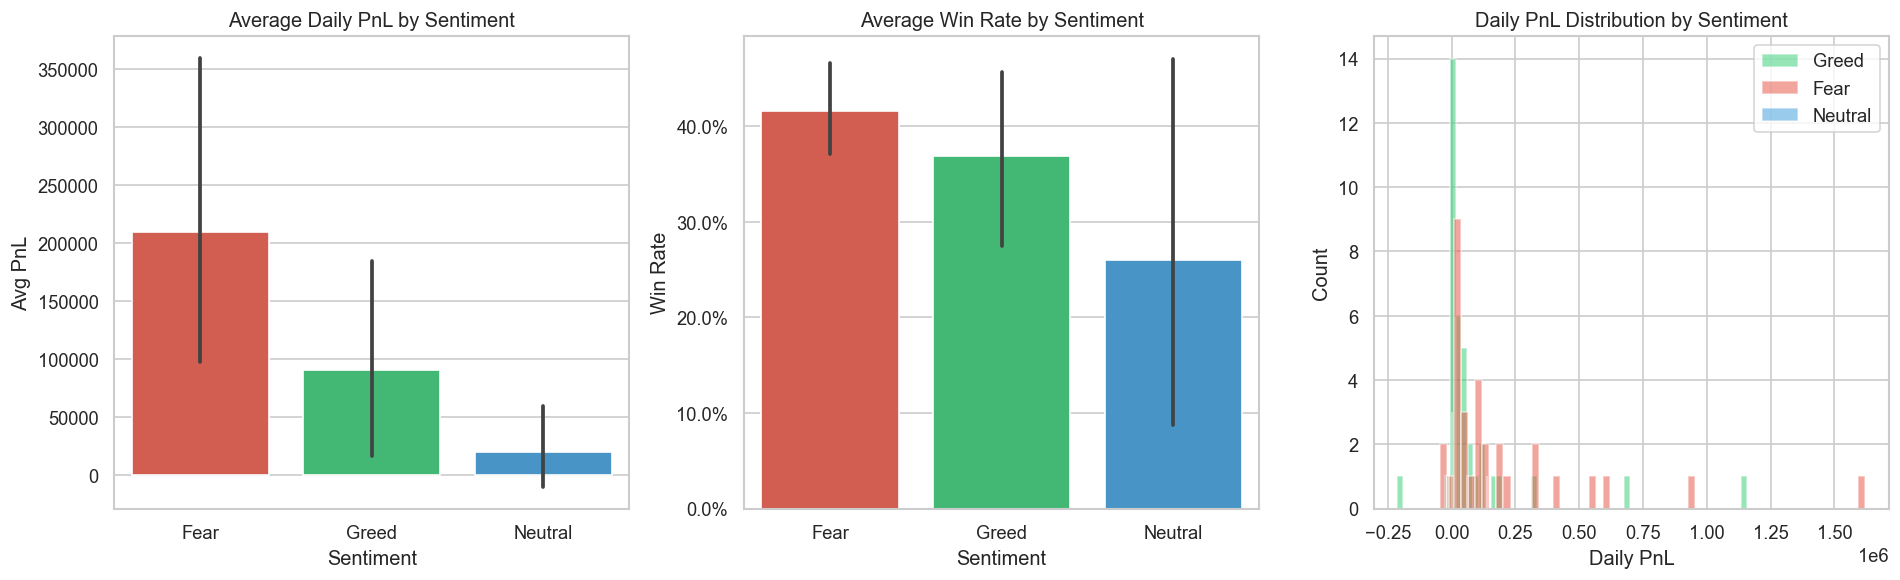

Saved: chart_pnl_sentiment.png


In [140]:
fig, axes = plt.subplots(1, 3, figsize=(16, 5))

palette = {'Fear': '#e74c3c', 'Greed': '#2ecc71', 'Neutral': '#3498db'}
sentiments = merged['sentiment_binary'].dropna().unique()
pal = {s: palette.get(s, 'grey') for s in sentiments}

# 1) Avg daily PnL
sns.barplot(data=merged, x='sentiment_binary', y='daily_pnl', estimator='mean',
            palette=pal, ax=axes[0], order=sorted(sentiments))
axes[0].set_title('Average Daily PnL by Sentiment')
axes[0].set_xlabel('Sentiment'); axes[0].set_ylabel('Avg PnL')

# 2) Win Rate
sns.barplot(data=merged, x='sentiment_binary', y='win_rate', estimator='mean',
            palette=pal, ax=axes[1], order=sorted(sentiments))
axes[1].set_title('Average Win Rate by Sentiment')
axes[1].set_xlabel('Sentiment'); axes[1].set_ylabel('Win Rate')
axes[1].yaxis.set_major_formatter(mticker.PercentFormatter(xmax=1))

# 3) Distribution of daily PnL
for s, color in pal.items():
    subset = merged[merged['sentiment_binary'] == s]['daily_pnl']
    subset = subset.clip(*subset.quantile([0.01, 0.99]))  # trim outliers for readability
    axes[2].hist(subset, bins=60, alpha=0.5, label=s, color=color)
axes[2].set_title('Daily PnL Distribution by Sentiment')
axes[2].set_xlabel('Daily PnL'); axes[2].set_ylabel('Count')
axes[2].legend()

plt.tight_layout()
plt.savefig('chart_pnl_sentiment.png', bbox_inches='tight')
plt.show()
print('Saved: chart_pnl_sentiment.png')

In [141]:
# Drawdown proxy: negative daily PnL / rolling 30-day peak PnL per trader
merged_sorted = merged.sort_values(['account', 'date'])
merged_sorted['rolling_peak'] = merged_sorted.groupby('account')['daily_pnl'].transform(
    lambda x: x.expanding().max()
)
merged_sorted['drawdown_proxy'] = merged_sorted['daily_pnl'] - merged_sorted['rolling_peak']

drawdown_summary = merged_sorted.groupby('sentiment_binary')['drawdown_proxy'].mean().round(4)
print('=== Drawdown Proxy by Sentiment ===')
print(drawdown_summary)

=== Drawdown Proxy by Sentiment ===
sentiment_binary
Fear      -69483.5173
Greed      -4212.9667
Neutral   -25739.2446
Name: drawdown_proxy, dtype: float64


### B2. Trader Behavior — Does Sentiment Change How Traders Act?

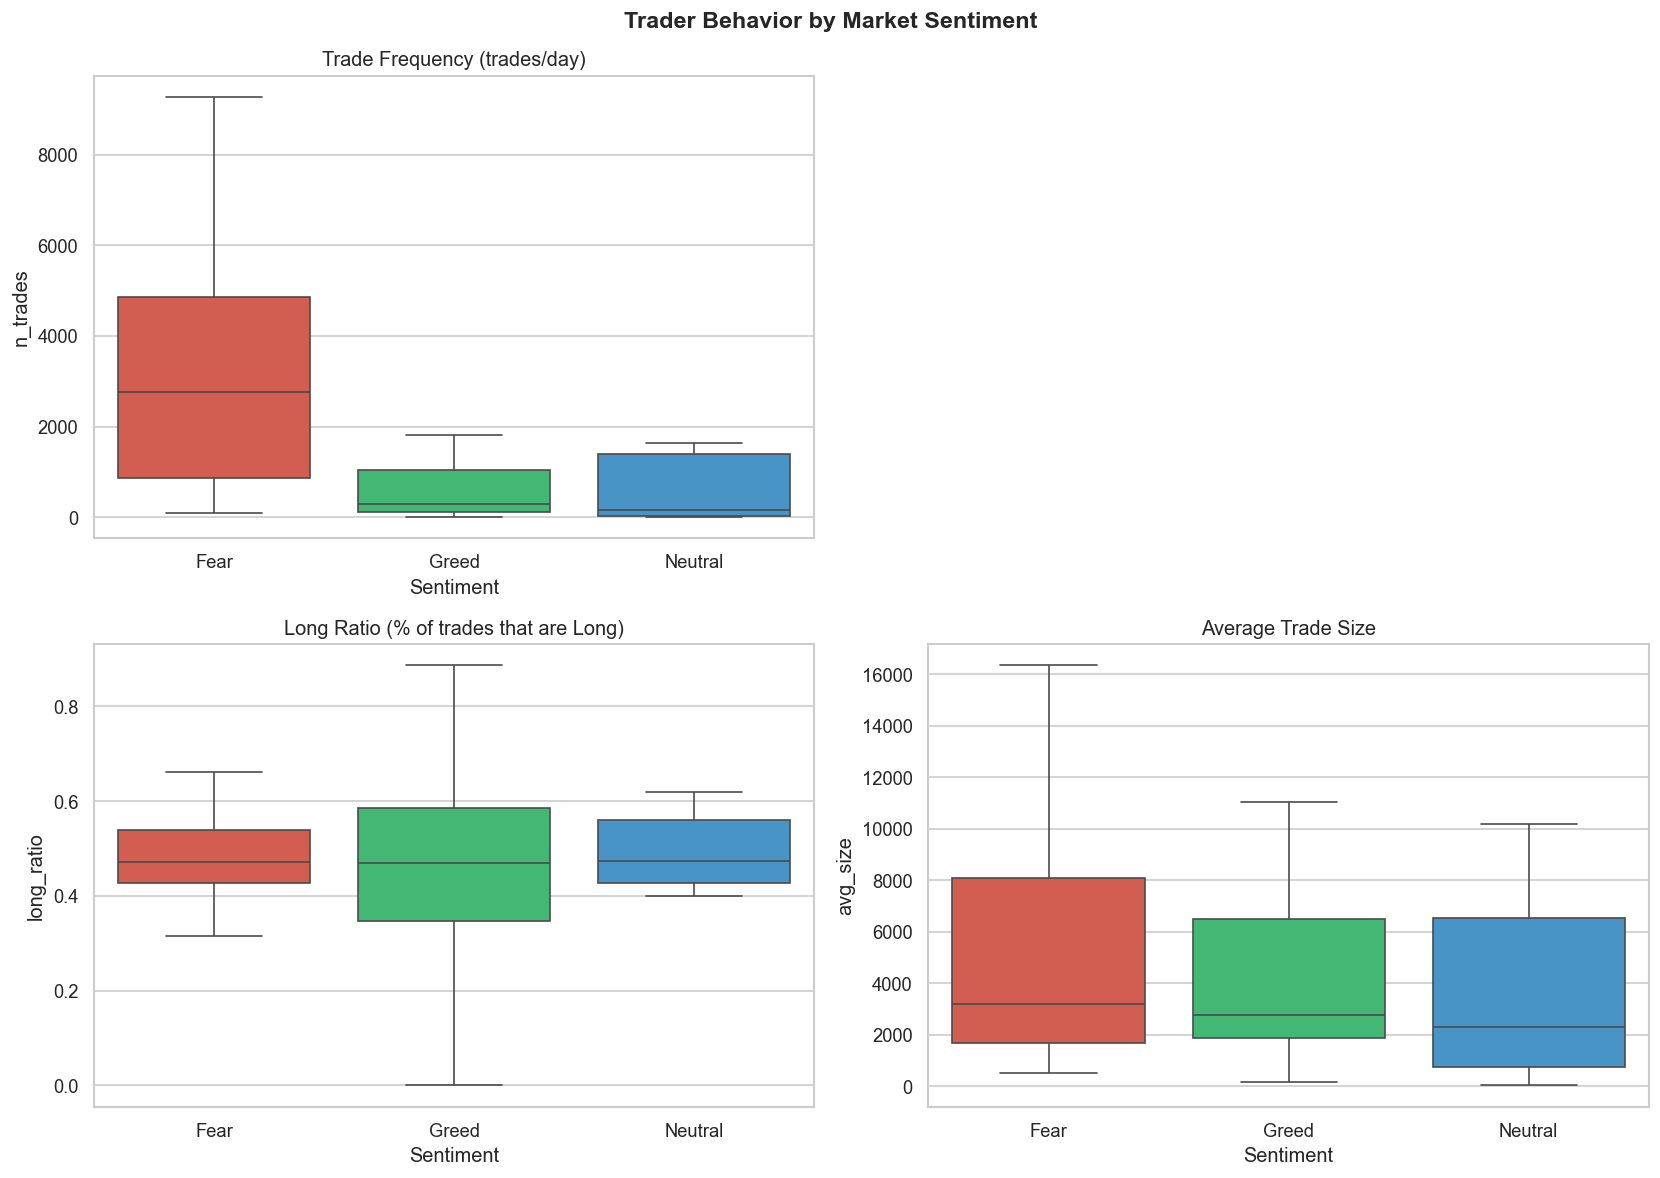

Saved: chart_behavior_sentiment.png


In [142]:
fig, axes = plt.subplots(2, 2, figsize=(14, 10))

metrics = [
    ('n_trades',    'Trade Frequency (trades/day)'),
    ('avg_leverage','Average Leverage'),
    ('long_ratio',  'Long Ratio (% of trades that are Long)'),
    ('avg_size',    'Average Trade Size'),
]

for ax, (col, label) in zip(axes.flat, metrics):
    if col not in merged.columns:
        ax.set_visible(False)
        continue
    sns.boxplot(data=merged, x='sentiment_binary', y=col, palette=pal,
                order=sorted(sentiments), ax=ax, showfliers=False)
    ax.set_title(label)
    ax.set_xlabel('Sentiment')

plt.suptitle('Trader Behavior by Market Sentiment', fontsize=14, fontweight='bold')
plt.tight_layout()
plt.savefig('chart_behavior_sentiment.png', bbox_inches='tight')
plt.show()
print('Saved: chart_behavior_sentiment.png')

In [ ]:
# Statistical significance test
from scipy import stats

fear_data  = merged[merged['sentiment_binary'] == 'Fear']
greed_data = merged[merged['sentiment_binary'] == 'Greed']

print('=== Mann-Whitney U Tests (Fear vs Greed) ===')
for col in ['daily_pnl', 'win_rate', 'avg_leverage', 'n_trades', 'long_ratio', 'avg_size']:
    if col not in merged.columns: continue
    f = fear_data[col].dropna()
    g = greed_data[col].dropna()
    if len(f) < 5 or len(g) < 5: continue
    stat, p = stats.mannwhitneyu(f, g, alternative='two-sided')
    sig = ' significant' if p < 0.05 else ' not significant'
    print(f'  {col:20s}  p={p:.4f}  {sig}')

=== Mann-Whitney U Tests (Fear vs Greed) ===
  daily_pnl             p=0.0134  ✅ significant
  win_rate              p=0.4889  ❌ not significant
  n_trades              p=0.0001  ✅ significant
  long_ratio            p=0.8709  ❌ not significant
  avg_size              p=0.7047  ❌ not significant


### B3. Trader Segmentation

In [144]:
# Per-trader aggregate profile
trader_profile = merged.groupby('account').agg(
    total_pnl       = ('daily_pnl',    'sum'),
    avg_daily_pnl   = ('daily_pnl',    'mean'),
    pnl_std         = ('daily_pnl',    'std'),
    total_trades    = ('n_trades',     'sum'),
    avg_win_rate    = ('win_rate',     'mean'),
    avg_long_ratio  = ('long_ratio',   'mean'),
    avg_size        = ('avg_size',     'mean'),
    n_active_days   = ('date',         'count'),
).reset_index()

# Sharpe-like ratio
trader_profile['sharpe_proxy'] = trader_profile['avg_daily_pnl'] / (trader_profile['pnl_std'] + 1e-9)

print(f'Unique traders: {len(trader_profile):,}')
display(trader_profile.describe().round(3))

Unique traders: 32


,total_pnl,avg_daily_pnl,pnl_std,total_trades,avg_win_rate,avg_long_ratio,avg_size,n_active_days,sharpe_proxy
count,32.000,32.000,29.000,32.000,32.000,32.000,32.000,32.000,29.000
mean,319539.050,146817.444,170500.255,5758.219,0.379,0.483,5664.861,2.406,1.337
std,463277.288,220206.578,308644.004,7589.403,0.135,0.128,5539.412,1.103,1.730
min,-27704.567,-4617.428,2481.039,332.000,0.144,0.233,508.414,1.000,-0.149
25%,49548.729,23833.746,30325.473,1113.250,0.255,0.406,2191.740,2.000,0.707
50%,120756.630,60378.315,66863.970,3152.500,0.411,0.481,3511.529,2.000,0.841
75%,396137.673,175627.998,162123.184,7694.250,0.477,0.533,5441.706,2.250,1.042
max,2040922.426,940157.213,1594696.643,36534.000,0.653,0.736,22504.556,6.000,7.599


In [145]:
# ── Segment 1: Frequent vs Infrequent ──
freq_median = trader_profile['n_active_days'].median()
trader_profile['freq_seg'] = np.where(
    trader_profile['n_active_days'] >= freq_median, 'Frequent', 'Infrequent'
)

# ── Segment 2: Consistent Winners vs Others ──
trader_profile['consistency_seg'] = 'Inconsistent'
mask_winner = (trader_profile['avg_win_rate'] >= 0.55) & (trader_profile['total_pnl'] > 0)
trader_profile.loc[mask_winner, 'consistency_seg'] = 'Consistent Winner'

# ── Segment 3: High Size vs Low Size ──
size_median = trader_profile['avg_size'].median()
trader_profile['size_seg'] = np.where(
    trader_profile['avg_size'] >= size_median, 'High Size', 'Low Size'
)

print('Frequency segment counts:')
print(trader_profile['freq_seg'].value_counts())
print('\nConsistency segment counts:')
print(trader_profile['consistency_seg'].value_counts())
print('\nSize segment counts:')
print(trader_profile['size_seg'].value_counts())

Frequency segment counts:
freq_seg
Frequent      29
Infrequent     3
Name: count, dtype: int64

Consistency segment counts:
consistency_seg
Inconsistent         29
Consistent Winner     3
Name: count, dtype: int64

Size segment counts:
size_seg
High Size    16
Low Size     16
Name: count, dtype: int64


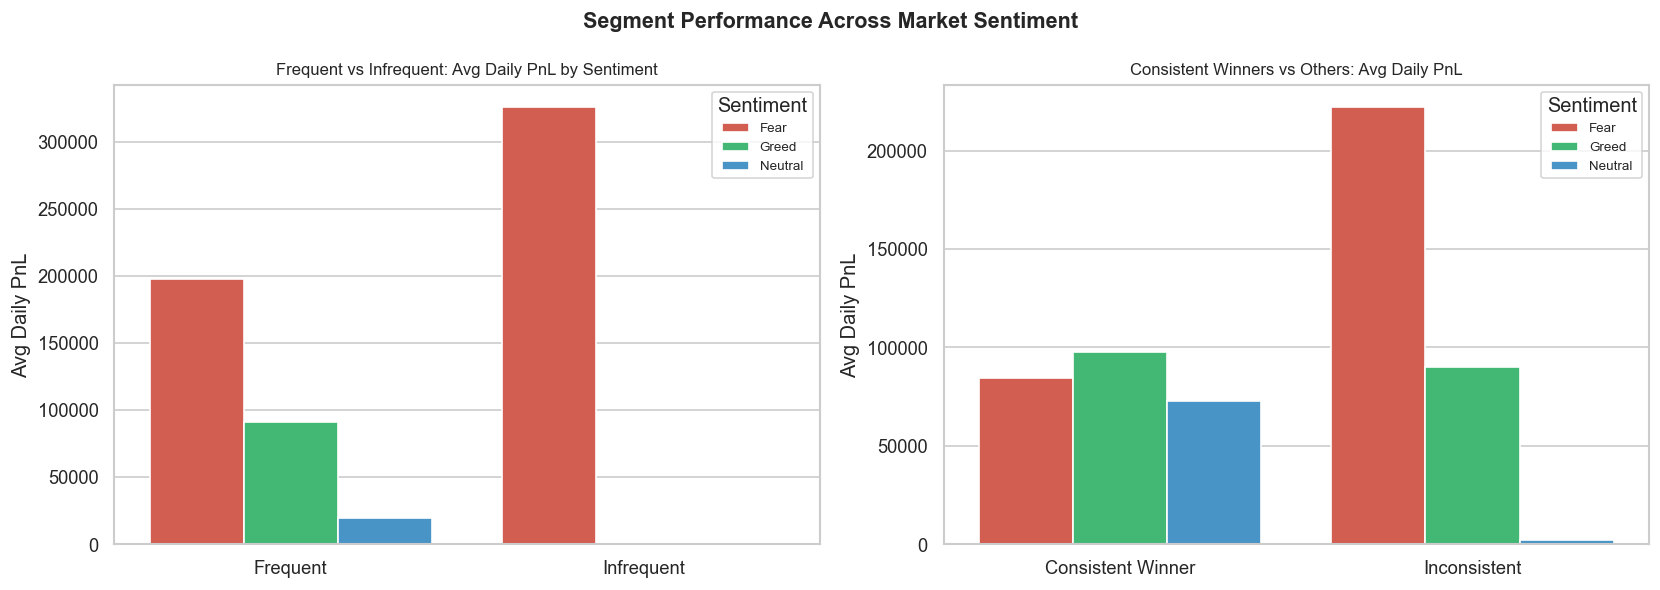

Saved: chart_segments.png


In [146]:
# Merge segments back into daily merged df
merged_seg = merged.merge(
    trader_profile[['account', 'freq_seg', 'consistency_seg', 'size_seg']],
    on='account', how='left'
)

fig, axes = plt.subplots(1, 2, figsize=(14, 5))

seg_configs = [
    ('freq_seg',         'Frequent vs Infrequent: Avg Daily PnL by Sentiment'),
    ('consistency_seg',  'Consistent Winners vs Others: Avg Daily PnL'),
]

for ax, (seg_col, title) in zip(axes, seg_configs):
    seg_summary = merged_seg.groupby([seg_col, 'sentiment_binary'])['daily_pnl'].mean().reset_index()
    sns.barplot(
        data=seg_summary, x=seg_col, y='daily_pnl',
        hue='sentiment_binary', palette=pal, ax=ax
    )
    ax.set_title(title, fontsize=10)
    ax.set_xlabel('')
    ax.set_ylabel('Avg Daily PnL')
    ax.legend(title='Sentiment', fontsize=8)

plt.suptitle('Segment Performance Across Market Sentiment', fontsize=13, fontweight='bold')
plt.tight_layout()
plt.savefig('chart_segments.png', bbox_inches='tight')
plt.show()
print('Saved: chart_segments.png')

### B4. Key Insights with Supporting Charts

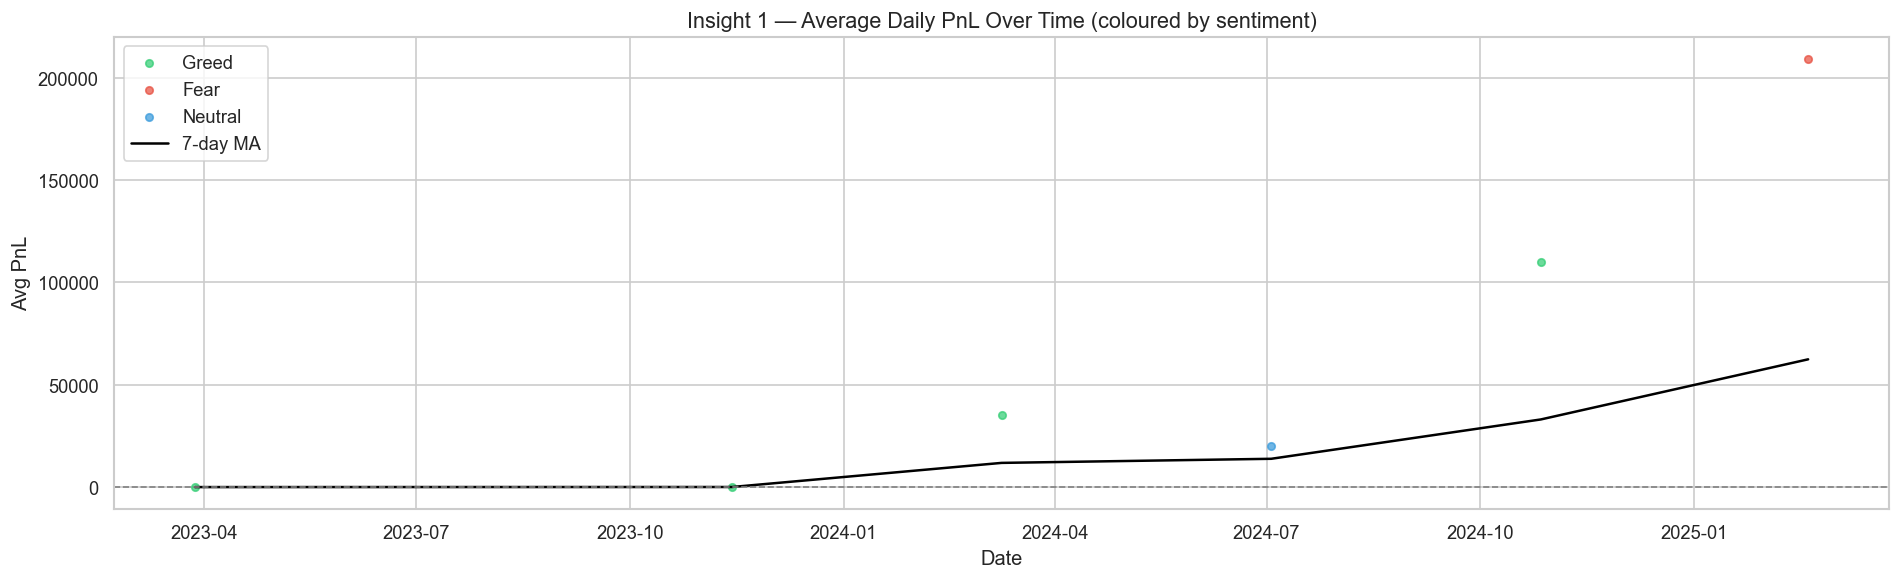

Saved: chart_insight1_timeseries.png


In [147]:
# ── Insight 1: Time-series of avg daily PnL coloured by sentiment ──
ts = daily_market.sort_values('date')

fig, ax = plt.subplots(figsize=(16, 5))
for s, color in pal.items():
    mask = ts['sentiment_binary'] == s
    ax.scatter(ts.loc[mask, 'date'], ts.loc[mask, 'avg_pnl'], label=s, color=color, alpha=0.7, s=20)

ax.plot(ts['date'], ts['avg_pnl'].rolling(7, min_periods=1).mean(), color='black', lw=1.5, label='7-day MA')
ax.axhline(0, color='grey', linestyle='--', lw=1)
ax.set_title('Insight 1 — Average Daily PnL Over Time (coloured by sentiment)', fontsize=13)
ax.set_xlabel('Date'); ax.set_ylabel('Avg PnL')
ax.legend()
plt.tight_layout()
plt.savefig('chart_insight1_timeseries.png', bbox_inches='tight')
plt.show()
print('Saved: chart_insight1_timeseries.png')

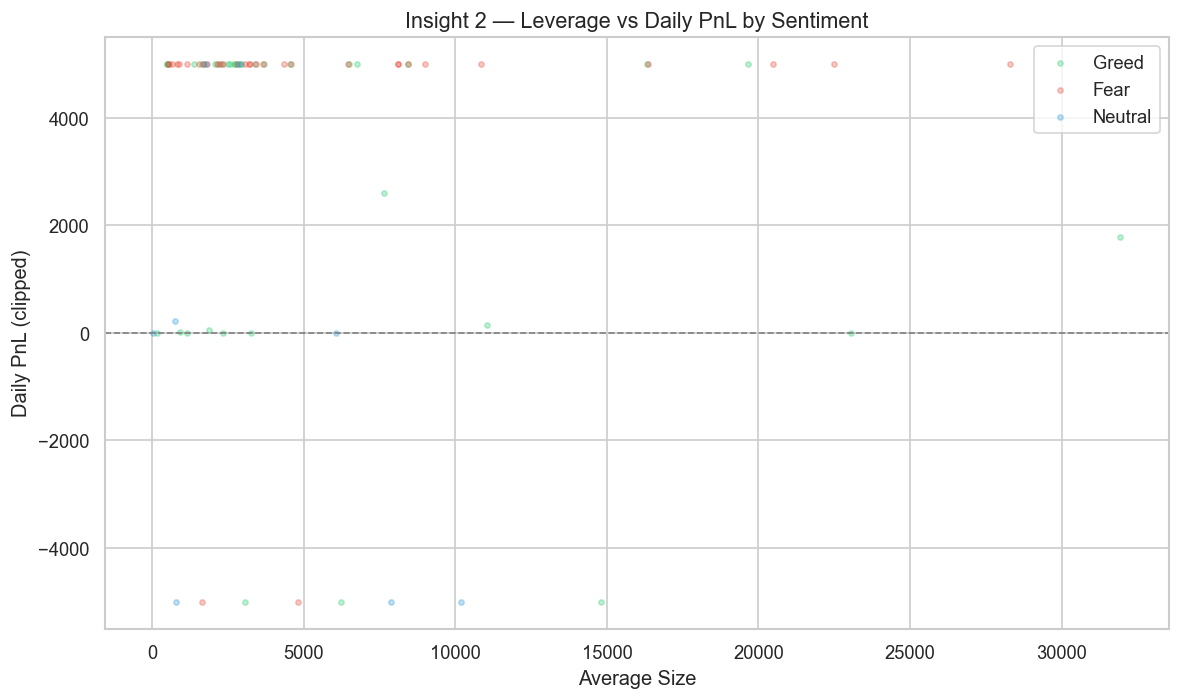

Saved: chart_insight2_leverage_pnl.png


In [148]:
# ── Insight 2: Leverage vs PnL scatter coloured by sentiment ──
sample = merged_seg.sample(min(5000, len(merged_seg)), random_state=42)

fig, ax = plt.subplots(figsize=(10, 6))
for s, color in pal.items():
    sub = sample[sample['sentiment_binary'] == s]
    ax.scatter(sub['avg_size'], sub['daily_pnl'].clip(-5000, 5000),
               alpha=0.3, s=10, label=s, color=color)

ax.axhline(0, color='grey', linestyle='--', lw=1)
ax.set_title('Insight 2 — Leverage vs Daily PnL by Sentiment', fontsize=13)
ax.set_xlabel('Average Size'); ax.set_ylabel('Daily PnL (clipped)')
ax.legend()
plt.tight_layout()
plt.savefig('chart_insight2_leverage_pnl.png', bbox_inches='tight')
plt.show()
print('Saved: chart_insight2_leverage_pnl.png')

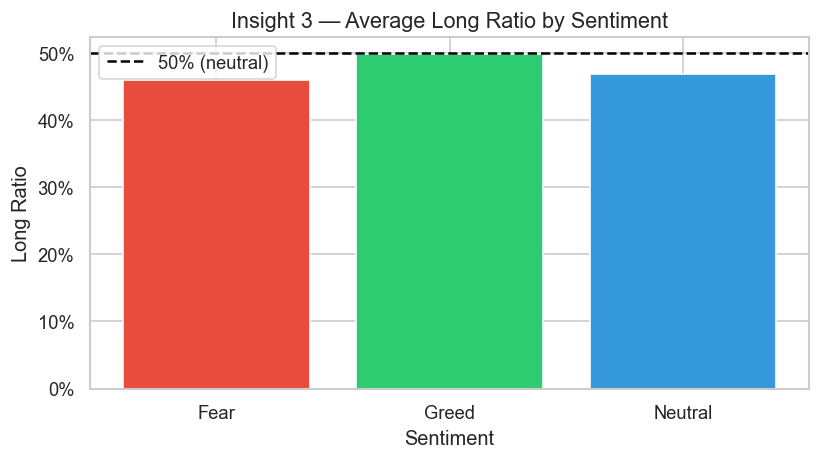

Saved: chart_insight3_long_ratio.png


In [149]:
# ── Insight 3: Long/Short bias shift during Fear vs Greed ──
long_ratio_summary = merged.groupby('sentiment_binary')['long_ratio'].mean().reset_index()

fig, ax = plt.subplots(figsize=(7, 4))
bars = ax.bar(
    long_ratio_summary['sentiment_binary'],
    long_ratio_summary['long_ratio'],
    color=[pal.get(s, 'grey') for s in long_ratio_summary['sentiment_binary']]
)
ax.axhline(0.5, color='black', linestyle='--', lw=1.5, label='50% (neutral)')
ax.set_title('Insight 3 — Average Long Ratio by Sentiment', fontsize=13)
ax.set_xlabel('Sentiment'); ax.set_ylabel('Long Ratio')
ax.yaxis.set_major_formatter(mticker.PercentFormatter(xmax=1))
ax.legend()
plt.tight_layout()
plt.savefig('chart_insight3_long_ratio.png', bbox_inches='tight')
plt.show()
print('Saved: chart_insight3_long_ratio.png')

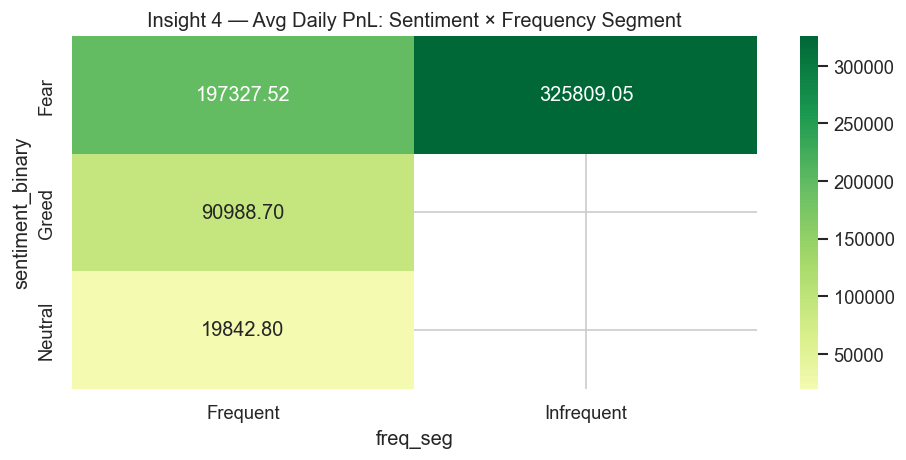

Saved: chart_insight4_heatmap.png


In [150]:
# ── Insight 4: Heatmap — Sentiment x Frequency Segment x Avg PnL ──
heat_data = merged_seg.groupby(['sentiment_binary', 'freq_seg'])['daily_pnl'].mean().unstack()

if not heat_data.empty:
    fig, ax = plt.subplots(figsize=(8, 4))
    sns.heatmap(heat_data, annot=True, fmt='.2f', cmap='RdYlGn', center=0, ax=ax)
    ax.set_title('Insight 4 — Avg Daily PnL: Sentiment × Frequency Segment', fontsize=12)
    plt.tight_layout()
    plt.savefig('chart_insight4_heatmap.png', bbox_inches='tight')
    plt.show()
    print('Saved: chart_insight4_heatmap.png')
else:
    print('No data available for heatmap.')

---
## Part C — Actionable Strategy Recommendations



In [151]:
# Strategy 1 evidence: High-size traders on Fear days
s1 = merged_seg[merged_seg['size_seg'] == 'High Size'].groupby('sentiment_binary')['daily_pnl'].agg(['mean','count'])
print('=== High-Size Traders: PnL by Sentiment ===')
print(s1)

# Strategy 2 evidence: Consistent winners on Fear days
s2 = merged_seg[merged_seg['consistency_seg'] == 'Consistent Winner'].groupby('sentiment_binary')['daily_pnl'].agg(['mean','count'])
print('\n=== Consistent Winners: PnL by Sentiment ===')
print(s2)

=== High-Size Traders: PnL by Sentiment ===
                           mean  count
sentiment_binary                      
Fear              278058.006946     16
Greed              84630.251772     20
Neutral             9202.357515      4

=== Consistent Winners: PnL by Sentiment ===
                          mean  count
sentiment_binary                     
Fear              84571.763549      3
Greed             97471.641641      5
Neutral           72781.805547      2


In [152]:
# Feature engineering
model_df = merged_seg.sort_values(['account', 'date']).copy()

# Lag features (yesterday's behaviour)
model_df['prev_pnl']      = model_df.groupby('account')['daily_pnl'].shift(1)
model_df['prev_n_trades'] = model_df.groupby('account')['n_trades'].shift(1)
model_df['prev_size'] = model_df.groupby('account')['avg_size'].shift(1)

# Target: is tomorrow profitable?
model_df['next_pnl'] = model_df.groupby('account')['daily_pnl'].shift(-1)
model_df['target']   = (model_df['next_pnl'] > 0).astype(int)

# Encode sentiment
model_df['sentiment_enc'] = LabelEncoder().fit_transform(model_df['sentiment_binary'].fillna('Unknown'))

feature_cols = [
    'prev_pnl', 'prev_n_trades', 'prev_size',
    'win_rate', 'avg_size', 'n_trades', 'long_ratio',
    'sentiment_enc'
]
feature_cols = [c for c in feature_cols if c in model_df.columns]

model_clean = model_df[feature_cols + ['target']].dropna()
print(f'Model dataset: {model_clean.shape}, target balance: {model_clean["target"].mean():.2%} positive')

X = model_clean[feature_cols]
y = model_clean['target']

X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42, stratify=y)

clf = RandomForestClassifier(n_estimators=200, max_depth=6, random_state=42, n_jobs=-1)
clf.fit(X_train, y_train)

y_pred = clf.predict(X_test)
print('\n=== Classification Report ===')
print(classification_report(y_test, y_pred))

Model dataset: (45, 9), target balance: 31.11% positive

=== Classification Report ===
              precision    recall  f1-score   support

           0       1.00      0.83      0.91         6
           1       0.75      1.00      0.86         3

    accuracy                           0.89         9
   macro avg       0.88      0.92      0.88         9
weighted avg       0.92      0.89      0.89         9



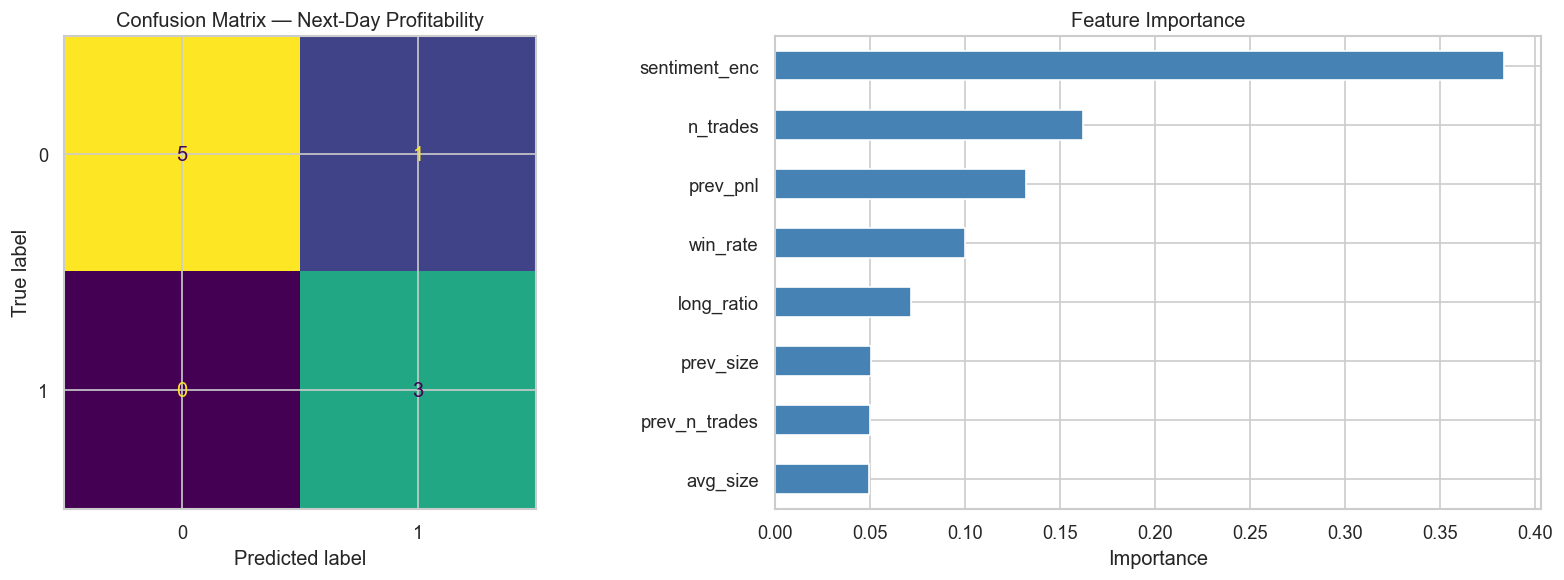

Saved: chart_model.png


In [153]:
fig, axes = plt.subplots(1, 2, figsize=(14, 5))

# Confusion matrix
ConfusionMatrixDisplay.from_predictions(y_test, y_pred, ax=axes[0], colorbar=False)
axes[0].set_title('Confusion Matrix — Next-Day Profitability')

# Feature importance
fi = pd.Series(clf.feature_importances_, index=feature_cols).sort_values(ascending=True)
fi.plot(kind='barh', ax=axes[1], color='steelblue')
axes[1].set_title('Feature Importance')
axes[1].set_xlabel('Importance')

plt.tight_layout()
plt.savefig('chart_model.png', bbox_inches='tight')
plt.show()
print('Saved: chart_model.png')

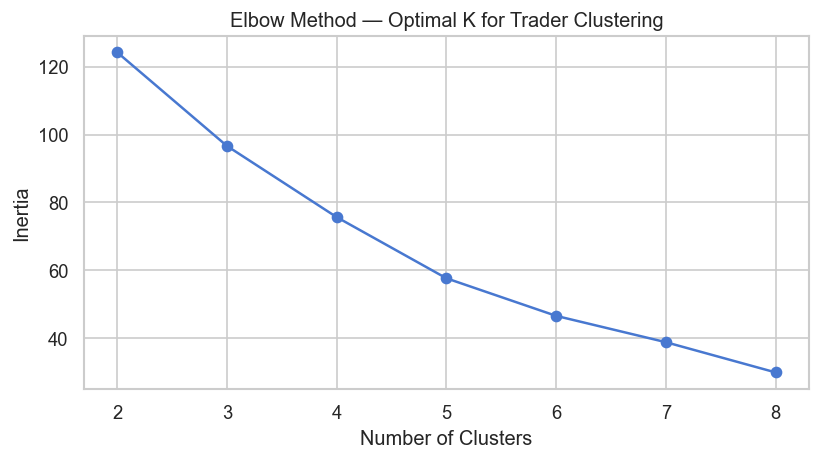

In [154]:
cluster_features = ['avg_daily_pnl', 'pnl_std', 'total_trades', 'avg_win_rate',
                    'avg_long_ratio', 'n_active_days']
cluster_features = [c for c in cluster_features if c in trader_profile.columns]

cluster_df = trader_profile[cluster_features].dropna()
scaler = StandardScaler()
X_scaled = scaler.fit_transform(cluster_df)

# Elbow method
inertias = []
K_range = range(2, 9)
for k in K_range:
    km = KMeans(n_clusters=k, random_state=42, n_init=10)
    km.fit(X_scaled)
    inertias.append(km.inertia_)

fig, ax = plt.subplots(figsize=(7, 4))
ax.plot(list(K_range), inertias, 'bo-')
ax.set_title('Elbow Method — Optimal K for Trader Clustering')
ax.set_xlabel('Number of Clusters'); ax.set_ylabel('Inertia')
plt.tight_layout()
plt.savefig('chart_elbow.png', bbox_inches='tight')
plt.show()

=== Cluster Centroids ===


,avg_daily_pnl,pnl_std,total_trades,avg_win_rate,avg_long_ratio,n_active_days
cluster,,,,,,
0,406887.987,503096.124,25472.000,0.405,0.413,3.5
1,56576.367,74475.113,3592.375,0.253,0.658,2.5
2,800114.910,1594696.643,3818.000,0.216,0.385,2.0
3,91901.624,97100.978,4065.556,0.430,0.418,2.5


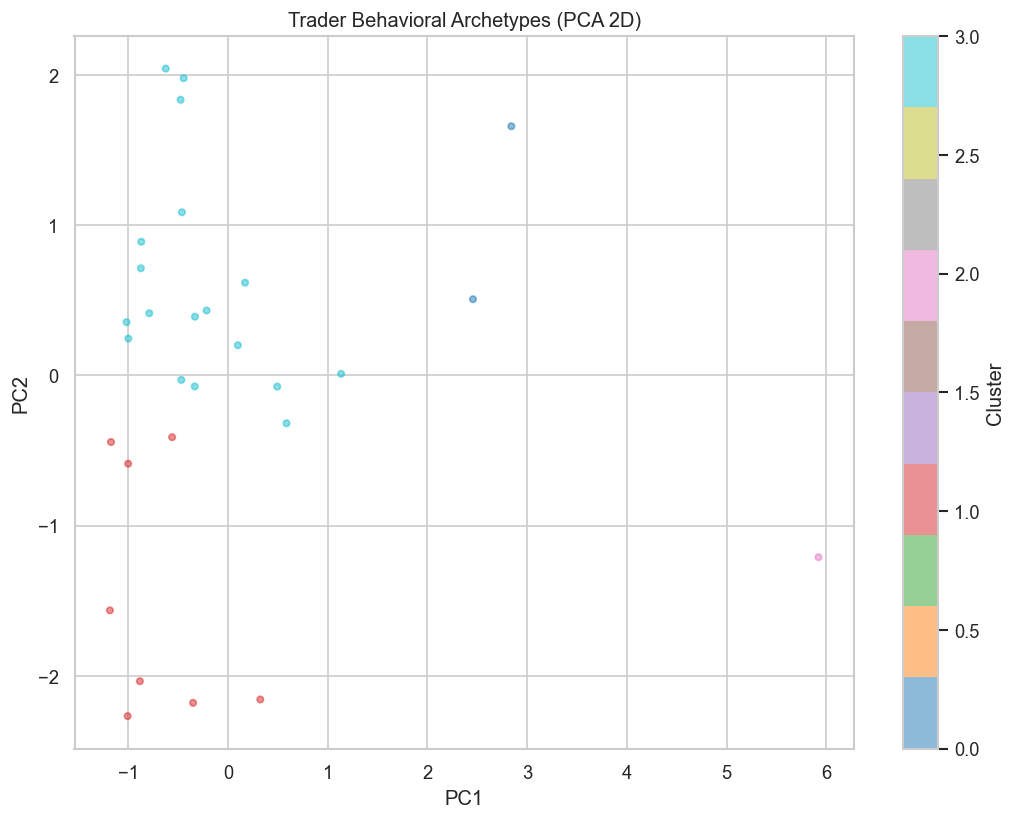

Saved: chart_clusters.png


In [155]:
N_CLUSTERS = 4  # adjust based on elbow above
km_final = KMeans(n_clusters=N_CLUSTERS, random_state=42, n_init=10)
cluster_df = cluster_df.copy()
cluster_df['cluster'] = km_final.fit_predict(X_scaled)

cluster_summary = cluster_df.groupby('cluster').mean().round(3)
print('=== Cluster Centroids ===')
display(cluster_summary)

# PCA for visualization
pca = PCA(n_components=2, random_state=42)
coords = pca.fit_transform(X_scaled)

fig, ax = plt.subplots(figsize=(9, 7))
scatter = ax.scatter(coords[:, 0], coords[:, 1], c=cluster_df['cluster'],
                     cmap='tab10', alpha=0.5, s=15)
plt.colorbar(scatter, ax=ax, label='Cluster')
ax.set_title('Trader Behavioral Archetypes (PCA 2D)')
ax.set_xlabel('PC1'); ax.set_ylabel('PC2')
plt.tight_layout()
plt.savefig('chart_clusters.png', bbox_inches='tight')
plt.show()
print('Saved: chart_clusters.png')

In [156]:
# Label archetypes based on centroids
# (labels assigned manually after inspecting cluster_summary above)
archetype_labels = {
    0: 'Archetype 0 — (inspect cluster_summary to name)',
    1: 'Archetype 1 — (inspect cluster_summary to name)',
    2: 'Archetype 2 — (inspect cluster_summary to name)',
    3: 'Archetype 3 — (inspect cluster_summary to name)',
}
# Common patterns to look for:
# High leverage + low win rate + high trade count → 'Aggressive Gambler'
# Low leverage + high win rate + low trade count  → 'Disciplined Scalper'
# High PnL + high std                             → 'High-Risk High-Reward'
# Low PnL + low std                               → 'Passive / Inactive'

print('Review cluster_summary above and assign archetype names in archetype_labels dict.')

Review cluster_summary above and assign archetype names in archetype_labels dict.
